In [1]:
from IPython.display import clear_output

**При первом запуске ноутбука запустите ячейку ниже, а затем при появлении кнопки <code>RESTART RUNTIME</code> нажмите на нее(или же перезапустите среду вручную через Среда выполнения->Перезапустить среду выполнения)** <br />
Потом по очереди запустите каждую из ячеек и перейдите к последней(ячейка "Results")

In [2]:
!pip3 install simpledemotivators

## Install environment

In [3]:
!pip3 install transformers==2.8.0
clear_output()

In [4]:
!pip3 install urllib3==1.25.4
!wget https://raw.githubusercontent.com/sberbank-ai/ru-gpts/master/pretrain_transformers.py
!wget https://raw.githubusercontent.com/sberbank-ai/ru-gpts/master/generate_transformers.py
clear_output()

In [5]:
!git clone https://github.com/NVIDIA/apex
!cd apex; python setup.py install
clear_output()

# Load and preprocessing data

## Load

In [6]:
!git clone https://github.com/Egoluback/neurowolf.git

Cloning into 'neurowolf'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


## Preprocessing

In [7]:
lines = []
with open("neurowolf/data/quotes.txt", "r") as file:
    lines = file.read().splitlines()

In [8]:
import pandas as pd

lines_ser = pd.Series(lines)

lines_ser

0       Пацан высказался, потом делом подтвердил слова...
1        Цена пацана измеряется выполнением его обещаний.
2       Я не матерюсь, а лишь употребляю ненормативную...
3       Самое позорное для пацана - поливать грязью ту...
4       Шесть лет не пил, не курил, по бабам не шлялся...
                              ...                        
1066    Если друзья мои станут врагами, и в суете прод...
1067    Никогда не говори людям о своих бедах, большин...
1068    Все хорошо. Земля вертится. Друзья звонят. И е...
1069    Когда идёшь на уступки ради человека, который ...
1070    Дай Бог тем людям, кто сказал про меня плохое,...
Length: 1071, dtype: object

In [9]:
lines_ser[lines_ser.map(lambda x: "—" in x)]

30           Мы, пацаны, не обижаемся — мы делаем выводы!
46      Если что не понял — читай по губам: «фак мусар...
47      Если любишь — люби без обмана. Если веришь — т...
62      Настоящая Братва — это единицы из сотен, что с...
63      Братва — это не когда вас много, а когда неско...
                              ...                        
1049    Для нас нет мусорского закона — мы пацаны с ра...
1050    Жизнь — хитрая штука. Как только у тебя в рука...
1054    Она мне даже не жена, но перед нею я в ответе,...
1060     Мой девиз четыре слова — ЗА БРАТВУ ПОРВУ ЛЮБОГО!
1063    Портят людей ни сигареты, ни алкоголь и ни обр...
Length: 185, dtype: object

In [10]:
lines_ser.unique().shape

(846,)

In [11]:
lines_ser.shape

(1071,)

In [12]:
lines_ser.iloc[25]

'Привыкнешь выживать - забудешь, как жить.'

In [13]:
with open("train.txt", "w+") as file:
    file.writelines(lines)

# Train and tests

## Train NLP model

In [14]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Файнтюним маленькую gpt3 модель(основанную на gpt2) от сбера <br />
Обучение длится не дольше двух минут

In [15]:
!python pretrain_transformers.py \
    --output_dir=model \
    --model_type=gpt2 \
    --model_name_or_path=sberbank-ai/rugpt3small_based_on_gpt2 \
    --do_train \
    --train_data_file=train.txt \
    --do_eval \
    --fp16 \
    --eval_data_file=valid.txt \
    --per_gpu_train_batch_size 1 \
    --gradient_accumulation_steps 1 \
    --num_train_epochs 5 \
    --block_size 2048 \
    --overwrite_output_dir

2021-08-15 12:10:30.278276: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
08/15/2021 12:10:32 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: True
08/15/2021 12:10:32 - INFO - filelock -   Lock 140577281423312 acquired on /root/.cache/torch/transformers/767f65149d3a8095b8ac0370c3b2bbc7f05d863ff413b010d2f5206de0349fd0.1ede3f500f8b09312434582244c28d34f008436c5a38bb3afa159d2b38f8e758.lock
08/15/2021 12:10:32 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/sberbank-ai/rugpt3small_based_on_gpt2/config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpfnubv783
Downloading: 100% 608/608 [00:00<00:00, 635kB/s]
08/15/2021 12:10:33 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/sberbank-ai/rugpt3small_based_on_gpt2/c

## Save model

In [16]:
# so far no need
# !cp -r model/  /content/drive/MyDrive/Neurowolf/

## Load model

In [17]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

path = "model"

tokenizer_gen = GPT2Tokenizer.from_pretrained(path)
model_gen = GPT2LMHeadModel.from_pretrained(path)
model_gen.to("cuda")

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [18]:
import copy

bad_word_ids = [
    [203], # \n
    [225], # weird space 1
    [28664], # weird space 2
    [13298], # weird space 3
    [206], # \r
    [49120], # html
    [25872], # http
    [3886], # amp
    [38512], # nbsp
    [10], # &
    [5436], # & (another)
    [5861], # http
    [372], # yet another line break
    [421, 4395], # МСК
    [64], # \
    [33077], # https
    [1572], # ru
    [11101], # Источник
]

def gen_fragment(context, bad_word_ids=bad_word_ids, print_debug_output=False, 
                 temperature=1.0, max_length=20, min_length=5):
    while True:
        input_ids = tokenizer_gen.encode(context, add_special_tokens=False, 
                                    return_tensors="pt").to("cuda")
        input_ids = input_ids[:, -1700:]
        input_size = input_ids.size(1)

        output_sequences = model_gen.generate(
            input_ids=input_ids,
            max_length=max_length + input_size,
            min_length=min_length + input_size,
            top_p=0.95,
            do_sample=True,
            num_return_sequences=1,
            temperature=1.0,
            pad_token_id=0,
            eos_token_id=2,
            bad_words_ids=bad_word_ids,
            no_repeat_ngram_size=10
        )

        if len(output_sequences.shape) > 2:
            output_sequences.squeeze_()
            
        generated_sequence = output_sequences[0].tolist()[input_size:]
        if print_debug_output:
            for idx in generated_sequence:
                print(idx, tokenizer_gen.decode([idx], clean_up_tokenization_spaces=True).strip())
        text = tokenizer_gen.decode(generated_sequence, clean_up_tokenization_spaces=True)
        if len(text) == 0 or text.rfind(".") == -1: continue
        text = text[: text.rfind(".") + 1]
        return context + text

## Generating demotivators

In [19]:
from simpledemotivators import Demotivator
from PIL import Image

import requests, re

def create_picture(start, picture_target="wolf"):
    r = requests.post(
        "https://api.deepai.org/api/text2img",
        data={'text': picture_target},
        headers={'api-key': '83bfdbfd-e539-4f7e-be8c-3a49325f8cac'}
    )

    url_image = r.json()['output_url']

    # sentences = re.split('\.|!|\..|\...|\?', gen_fragment(start + " ").replace("»", '').replace("«", '').replace('"', ''))
    sentences = gen_fragment(start).replace("»", '').replace("«", '').replace('"', '').replace('...', '.').replace('!', '.').replace('?', '.').split('.')

    if len(sentences) > 1:
        dem = Demotivator(sentences[0], sentences[1])
    else:
        dem = Demotivator(sentences[0])

    dem.create(url_image, fonttext='neurowolf/data/Arial_GEO.TTF', url=True, size2=50, size3=80)

[SimpleDemotivators] Данная версия библиотеки устарела, обновитесь до v2.0.1 с GitHub
Изменения: 2 новых аргумента в Demotivator: url, delete_file


In [20]:
begin_phrases = ['Своих друзей',
                'Спасибо Богу',
                'Это моя жизнь',
                'Слово пацана',
                'Пацан сказал',
                'Достойная девушка не',
                'Не прощай',
                'Сука, пацаны, берегите',
                'Чётко - это когда',
                'Брат - это',
                'За братву',
                'Моя братва',
                'Настоящий пацан',
                'Пацан не станет',
                'Быть пацаном - значит',
                'Как жаль, что я живу в стране,',
                 "Вот это мужик, а вы, девчёнки, и дальше"]

# Results

Генерация случайной пацанской цитаты, используя подготовленные заранее "затравки" <br />
В качестве запроса изображения - волк

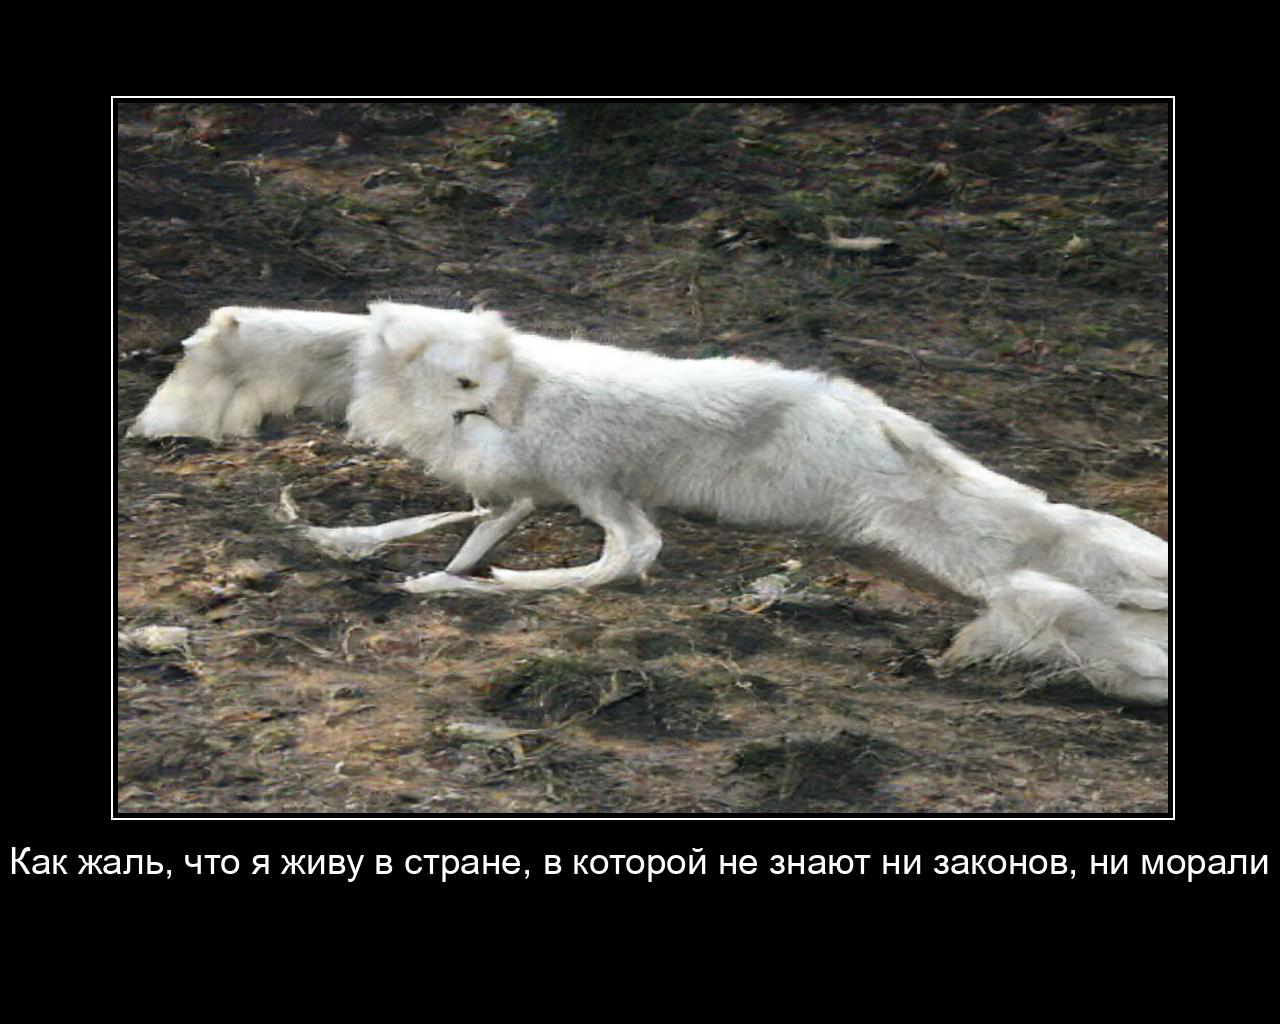

In [21]:
from random import choice

create_picture(choice(begin_phrases))
Image.open('demresult.jpg')

Генерация кастомной пацанской цитаты(можно ввести задел самому) <br />
Запрос для изображения указывается также самостоятельно(параметр picture_target)


In [30]:
phrase_begin = input('Введите "затравку" для цитаты: ')

Введите "затравку" для цитаты: Шоколад ни в чем не виноват,


Для повторного указания фразы перезапустите ячейку выше.

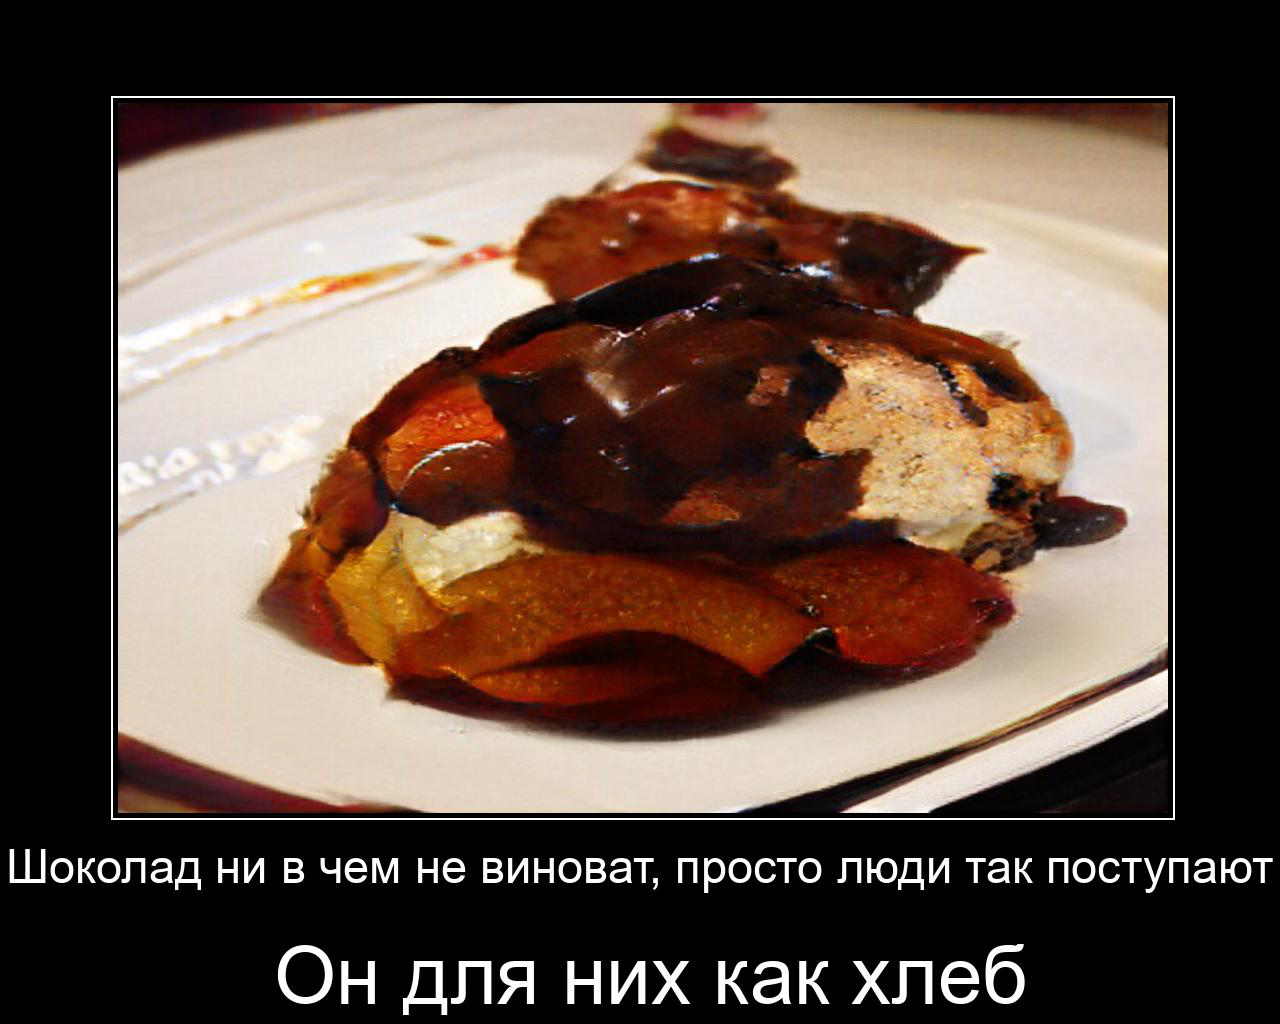

In [32]:
create_picture(phrase_begin, picture_target="chocolate")
Image.open('demresult.jpg')